## Логические методы классификации


### Цель работы

изучение принципов построения информационных систем с использованием логических методов классификации.

### Задачи 

 - освоение технологии внедрения алгоритмов на онове решающих списков в приложения;
 - освоение технологии внедрения алгоритмов на онове решающих деревьев в приложения;
 - изучение параметров логической классификации;
 - освоение модификаций логических методов классификации.

### Ход работы
#### 1 Подготовка данных

In [38]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import graphviz
from matplotlib import pyplot as plt
%matplotlib inline

RANDOM_STATE=42

In [39]:
data_source = "./Titanic-Dataset.csv"
data = pd.read_csv(data_source, delimiter=',')

data.rename(columns={"Sex": 'IsFemale'}, inplace=True)
data.replace({'IsFemale': {'female': 1, 'male': 0}}, inplace=True)

feats = ['Pclass', 'IsFemale', 'Age', 'SibSp', 'Parch', 'Fare']
target = 'Survived'

for feat in feats:
    mean = data[feat].mean()
    data[feat].fillna(mean, inplace=True)
    
print(data[[*feats, target]].head(10))

X = data[feats]
Y = data[target]

   Pclass  IsFemale        Age  SibSp  Parch     Fare  Survived
0       3         0  22.000000      1      0   7.2500         0
1       1         1  38.000000      1      0  71.2833         1
2       3         1  26.000000      0      0   7.9250         1
3       1         1  35.000000      1      0  53.1000         1
4       3         0  35.000000      0      0   8.0500         0
5       3         0  29.699118      0      0   8.4583         0
6       1         0  54.000000      0      0  51.8625         0
7       3         0   2.000000      3      1  21.0750         0
8       3         1  27.000000      0      2  11.1333         1
9       2         1  14.000000      1      0  30.0708         1


#### 2 Построение логического классификатора

##### 2.1 Построение модели с произвольными значениями максимальной глубины дерева и максимального количества признаков разделения дерева

In [40]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=RANDOM_STATE)

decision_tree = DecisionTreeClassifier(
    max_depth=5,
    max_features=2,
    random_state=RANDOM_STATE,
)

decision_tree.fit(X_train, Y_train)
accur = accuracy_score(Y_train, decision_tree.predict(X_train))
print(accur)

0.8202247191011236


##### 2.2  Построение модели с оптимальными гиперпараметрами

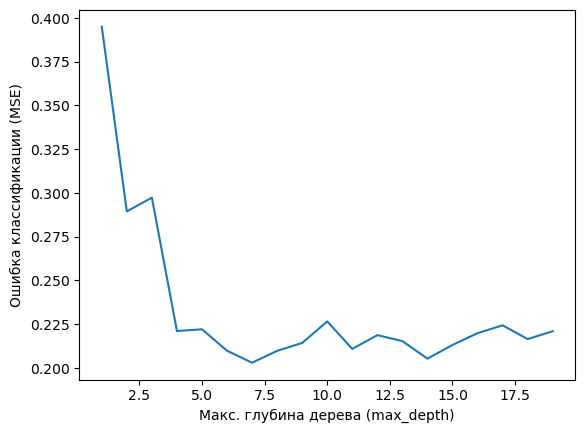

Оптимальные значения max_depth:  [7]


In [41]:
cv_scores = []

depths=list(range(1, 20))

for depth in depths:
    decision_tree = DecisionTreeClassifier(
        max_depth=depth,
        max_features=2,
        random_state=RANDOM_STATE,
    )
    
    scores = cross_val_score(decision_tree, X, Y, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())

MSE = [1-x for x in cv_scores]

plt.plot(depths, MSE)
plt.xlabel('Макс. глубина дерева (max_depth)');
plt.ylabel('Ошибка классификации (MSE)')
plt.show()

mse_min = min(MSE)

optimal_depths = []
for i in range(len(MSE)):
    if MSE[i] <= mse_min:
        optimal_depths.append(depths[i])

print('Оптимальные значения max_depth: ', optimal_depths)

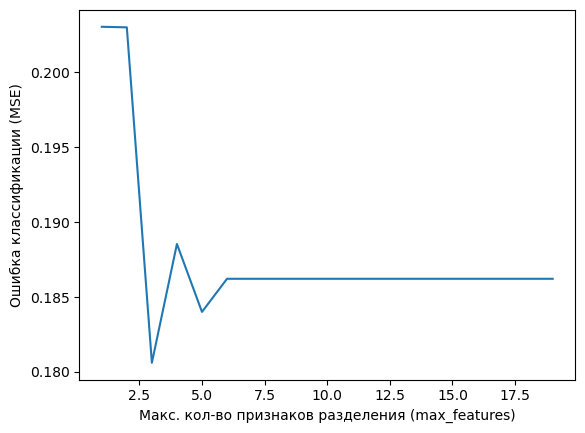

Оптимальные значения max_features:  [3]


In [42]:
cv_scores = []

max_features_counts=list(range(1, 20))

for max_features_count in max_features_counts:
    decision_tree = DecisionTreeClassifier(
        max_depth=optimal_depths[0],
        max_features=max_features_count,
        random_state=RANDOM_STATE,
    )
    
    scores = cross_val_score(decision_tree, X, Y, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())

MSE = [1-x for x in cv_scores]

plt.plot(depths, MSE)
plt.xlabel('Макс. кол-во признаков разделения (max_features)');
plt.ylabel('Ошибка классификации (MSE)')
plt.show()

mse_min = min(MSE)

optimal_max_features_counts = []
for i in range(len(MSE)):
    if MSE[i] <= mse_min:
        optimal_max_features_counts.append(max_features_counts[i])

print('Оптимальные значения max_features: ', optimal_max_features_counts)

In [43]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=RANDOM_STATE)

decision_tree = DecisionTreeClassifier(
    max_depth=optimal_depths[0],
    max_features=optimal_max_features_counts[0],
    random_state=RANDOM_STATE,
)

decision_tree.fit(X_train, Y_train)

DecisionTreeClassifier(max_depth=7, max_features=3, random_state=42)

In [44]:
feats_val = []
for feat in feats:
    val = int(input(f"Enter the {feat}: "))
    feats_val.append(val)
    
X_new = pd.DataFrame(np.array([feats_val]), columns=feats)
target = decision_tree.predict(X_new)

if target == 0:
    print('You are dead...')
elif target == 1:
    print('You are still alive!!!')

Enter the Pclass: 1
Enter the IsFemale: 0
Enter the Age: 20
Enter the SibSp: 0
Enter the Parch: 0
Enter the Fare: 88
You are still alive!!!


#### 3 Вывод оптимального дерева решений

In [45]:
decision_tree = DecisionTreeClassifier(
    max_depth=10, 
    random_state=RANDOM_STATE, 
    max_features=2
)

tree_params = { 
    'max_depth': range(1,20), 
    'max_features': range(1,4) 
}

tree_grid = GridSearchCV(
    decision_tree, 
    tree_params, 
    cv=10, 
    verbose=True,
    n_jobs=-1
)

tree_grid.fit(X, Y)

print('\n')
print('Лучшее сочетание параметров: ', tree_grid.best_params_)
print('Лучшие баллы cross validation: ', tree_grid.best_score_)

optimal_tree = tree_grid.best_estimator_

Fitting 10 folds for each of 57 candidates, totalling 570 fits


Лучшее сочетание параметров:  {'max_depth': 6, 'max_features': 3}
Лучшие баллы cross validation:  0.8237827715355805


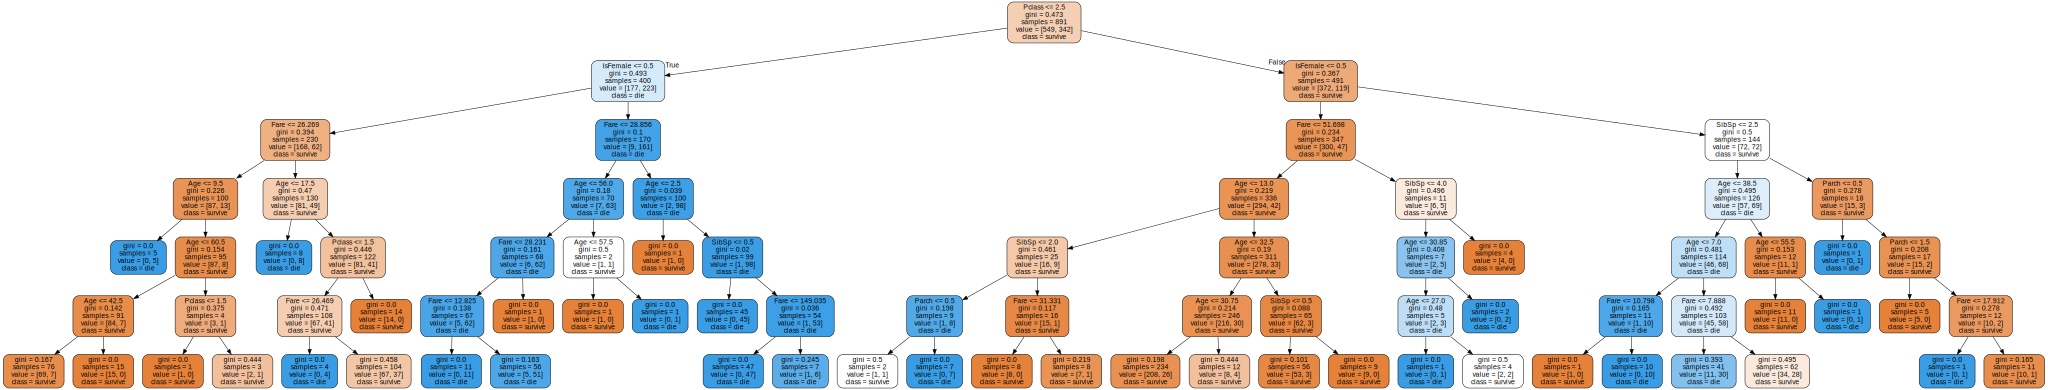

In [48]:
export_graphviz(
     optimal_tree, 
     feature_names=X.columns,
     class_names=['survive', 'die'],
     out_file='./tree.dot',  
     filled=True, 
     rounded=True
)

with open('./tree.dot') as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

#### 4 Вывод решающих границ

/tmp/ipykernel_27977/3221566212.py:19: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  p[p==answers[0]] = 0
/tmp/ipykernel_27977/3221566212.py:20: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  p[p==answers[1]] = 1


IndexError: list index out of range

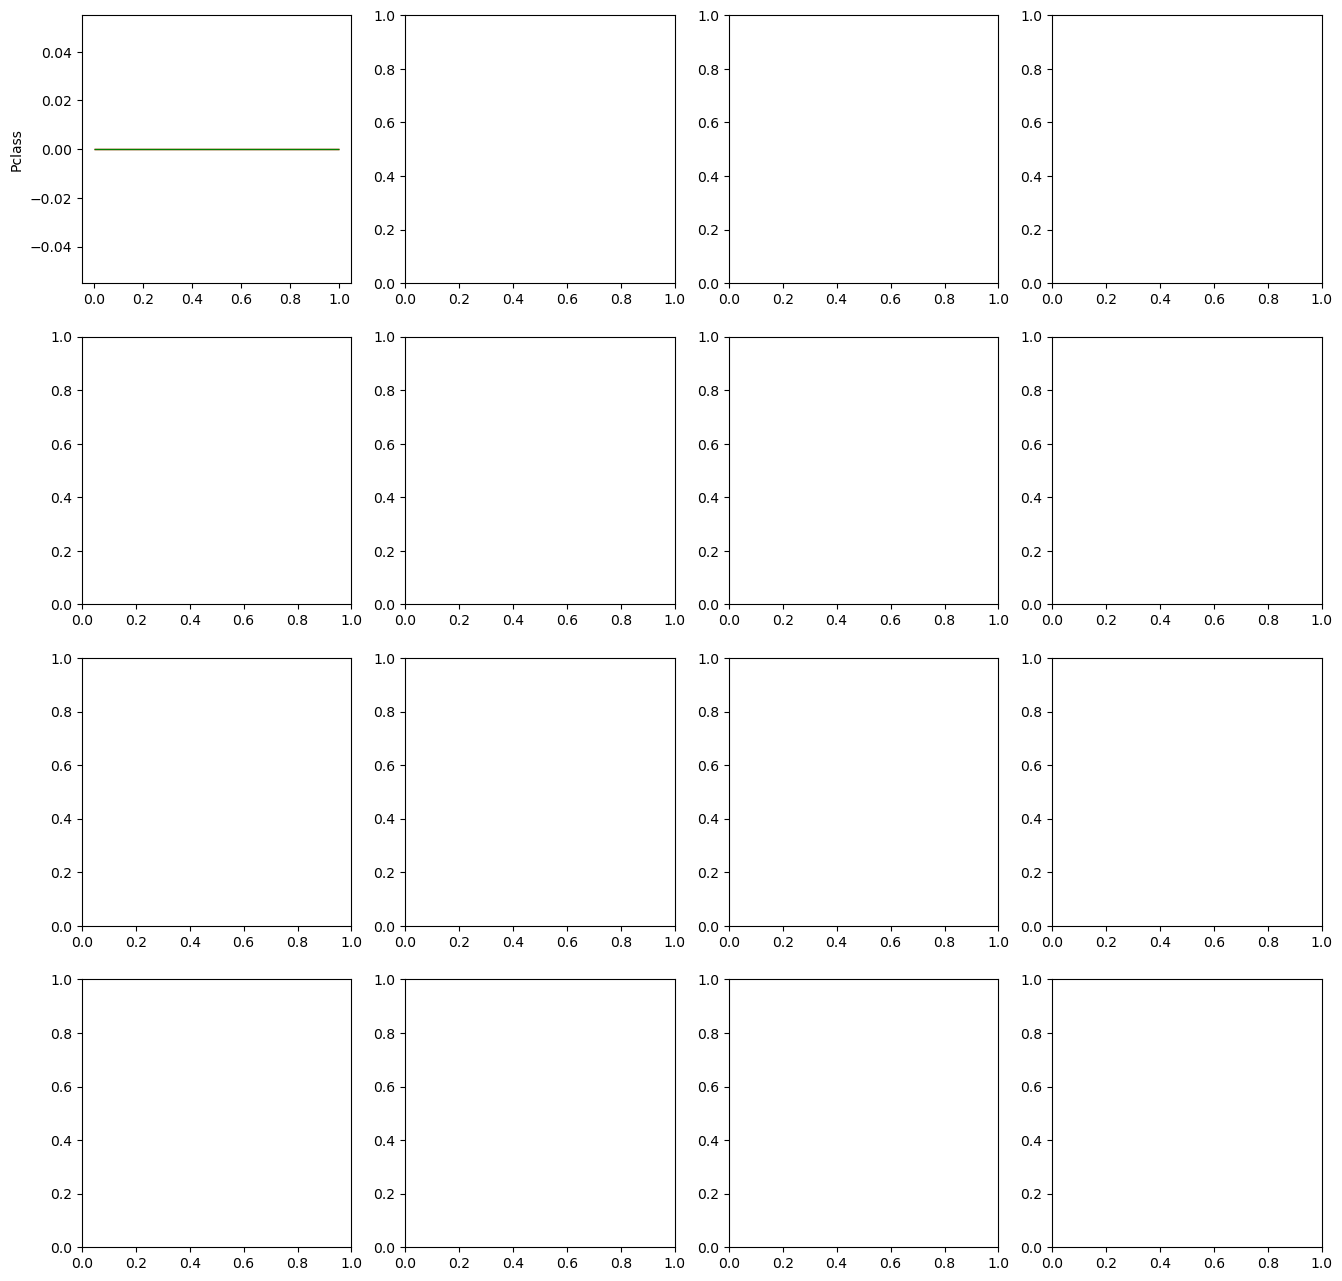

In [50]:
plot_markers = ['r*', 'g^', 'bo']
answers = ["survive", 'die']

f, places = plt.subplots(4, 4, figsize=(16,16))

fmin = X.min()-0.5
fmax = X.max()+0.5
plot_step = 0.02  

for i in range(0,4):
    for j in range(0,4):
        if(i != j):
            xx, yy = np.meshgrid(np.arange(fmin[i], fmax[i], plot_step),
                               np.arange(fmin[j], fmax[j], plot_step))
            model = DecisionTreeClassifier(max_depth=3, random_state=21, max_features=2)
            model.fit(X.iloc[:, [i,j]].values, Y)
            p = model.predict(np.c_[xx.ravel(), yy.ravel()])
            p = p.reshape(xx.shape)
            p[p==answers[0]] = 0
            p[p==answers[1]] = 1
            p[p==answers[2]] = 2
            xx = xx.astype(np.float32)
            yy = yy.astype(np.float32)
            p = p.astype(np.float32)
            places[i,j].contourf(xx, yy, p, cmap='Pastel1') 
      
        for id_answer in range(len(answers)):
            idx = np.where(Y == answers[id_answer])
            if i==j:
                places[i, j].hist(X.iloc[idx].iloc[:,i],
                                  color=plot_markers[id_answer][0],
                                 histtype = 'step')
            else:
                places[i, j].plot(X.iloc[idx].iloc[:,i], X.iloc[idx].iloc[:,j], 
                                  plot_markers[id_answer], 
                                  label=answers[id_answer], markersize=6)
        if j==0:
            places[i, j].set_ylabel(X.columns[j])
        
        if i==3:
            places[i, j].set_xlabel(X.columns[i])

### Контрольные вопросы

1. Поясните принцип построения дерева решений.
2. Укажите статистическое определение информативности.
3. Поясните энтропийное определение информативности.
4. Что такое многоклассовая информативность? Для чего она применяется?
5. Поясните назначение и алгоритм бинаризации количественных признаков.
6. Поясните порядок поиска закономерностей в форме конъюнкций.